<a href="https://colab.research.google.com/github/Imparth2803/Data-Science-Project/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extracting dataset from zipfile

In [2]:
# Define file paths
zip_path = "/content/drive/MyDrive/ISIC_2019_Training_Input.zip"
csv_path = "/content/drive/MyDrive/ISIC_2019_Training_Metadata.csv"
extract_path = "/content/ISIC_2019_Training_Input"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Exploratory Data Analysis(EDA)

In [3]:
df = pd.read_csv(csv_path)

# Display first 5 rows
print(df.head())

# Show dataset info
df.info()

print(df.isnull().sum())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
image                     0
age_approx              437
anatom_site_general    2631
lesion_i

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill missing values
df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())

# Fill missing sex values with "unknown"
df['sex'] = df['sex'].fillna("unknown")

# Verify again
print(df.isnull().sum())

Missing Values:
 image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64
image                     0
age_approx                0
anatom_site_general    2631
lesion_id              2084
sex                       0
dtype: int64


In [5]:
# Drop rows with null values in the "anatom_site_general" column
df = df.dropna(subset=['anatom_site_general'])

df = df.dropna(subset=['lesion_id'])

# Verify
print(df.isnull().sum())

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64


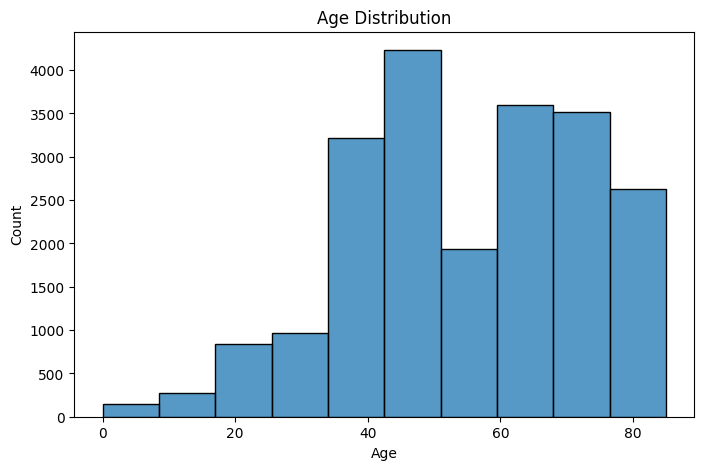

In [6]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["age_approx"], bins=10)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

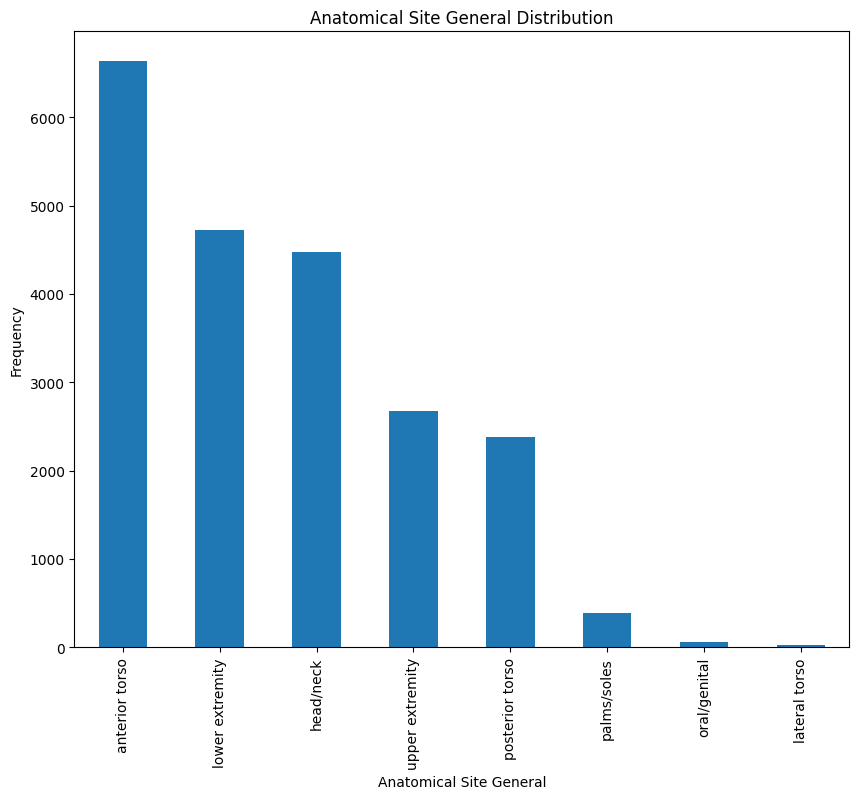

In [7]:
plt.figure(figsize=(10, 8))
df['anatom_site_general'].value_counts().plot(kind='bar')
plt.title('Anatomical Site General Distribution')
plt.xlabel('Anatomical Site General')
plt.ylabel('Frequency')
plt.show()

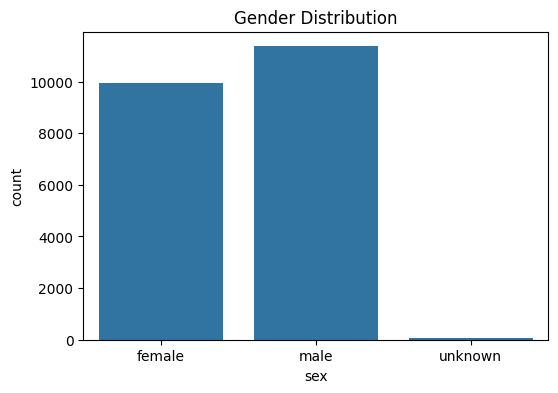

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x="sex", data=df)
plt.title("Gender Distribution")
plt.show()

In [9]:
lesion_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"

In [10]:
df_lesion = pd.read_csv(lesion_path)

# Display first 5 rows
print(df_lesion.head())

# Show dataset info
df_lesion.info()

print(df_lesion.isnull().sum())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
image    0
MEL      0
N

MEL      4522.0
NV      12875.0
BCC      3323.0
AK        867.0
BKL      2624.0
DF        239.0
VASC      253.0
SCC       628.0
UNK         0.0
dtype: float64


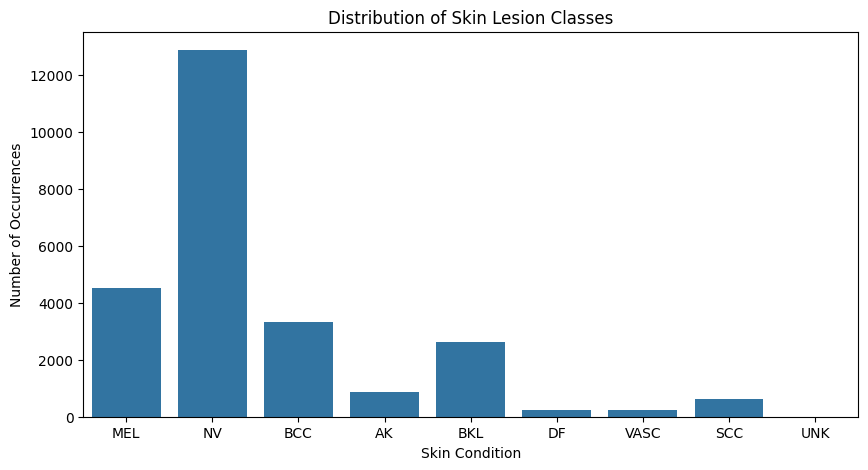

In [11]:
positive_counts = df_lesion.iloc[:, 1:].sum()
print(positive_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=positive_counts.index, y=positive_counts.values)
plt.xlabel("Skin Condition")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Skin Lesion Classes")
plt.show()

# Preprocessing Images

In [12]:
# Load the CSV file
csv_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"
df = pd.read_csv(csv_path)

# Assuming the first column is 'image_name' and the next 8 columns are one-hot encoded classes
image_column = df.columns[0]  # First column name (Image names)
class_columns = df.columns[1:]  # All other columns (One-hot encoded labels)

# Convert one-hot encoding back to categorical labels
df["Disease"] = df[class_columns].idxmax(axis=1)

# Keep only two columns: Image name and Disease label
df = df[[image_column, "Disease"]]

# Save the updated CSV
df.to_csv("updated_dataset.csv", index=False)

updated_csv = "/content/updated_dataset.csv"
df_updated = pd.read_csv(updated_csv)

# Display first 5 rows
print(df_updated.head())

# Show dataset info
df_updated.info()

print(df_updated.isnull().sum())

          image Disease
0  ISIC_0000000      NV
1  ISIC_0000001      NV
2  ISIC_0000002     MEL
3  ISIC_0000003      NV
4  ISIC_0000004     MEL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    25331 non-null  object
 1   Disease  25331 non-null  object
dtypes: object(2)
memory usage: 395.9+ KB
image      0
Disease    0
dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def one_hot_encode(image, label, num_classes):
    label = tf.one_hot(label, num_classes)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

def get_isic_dataset(image_dir, csv_path, batch_size, augment_data=False):

    # Load the CSV
    df = pd.read_csv(csv_path)

    # Encode disease labels into numeric values
    le = LabelEncoder()
    df['Label'] = le.fit_transform(df['Disease'])

    # Store label mapping for later use (e.g. decoding predictions)
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Label Mapping:", label_mapping)

    # Generate full image paths
    image_paths = [os.path.join(image_dir, fname + ".jpg") for fname in df['image']]
    labels = df['Label'].values
    num_classes = len(label_mapping)

    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y))
    dataset = dataset.map(lambda x, y: one_hot_encode(x, y, num_classes))

    if augment_data:
        dataset = dataset.map(augment)

    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example usage:
image_dir = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
csv_path = "/content/updated_dataset.csv"
batch_size = 32

isic_dataset = get_isic_dataset(image_dir, csv_path, batch_size, augment_data=True)

Label Mapping: {'AK': np.int64(0), 'BCC': np.int64(1), 'BKL': np.int64(2), 'DF': np.int64(3), 'MEL': np.int64(4), 'NV': np.int64(5), 'SCC': np.int64(6), 'VASC': np.int64(7)}


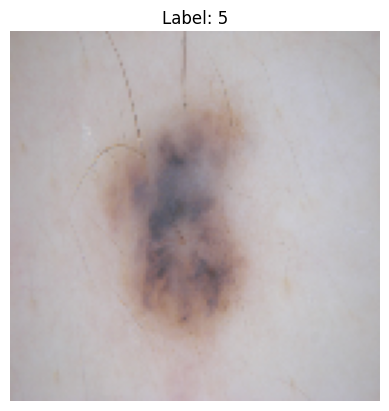

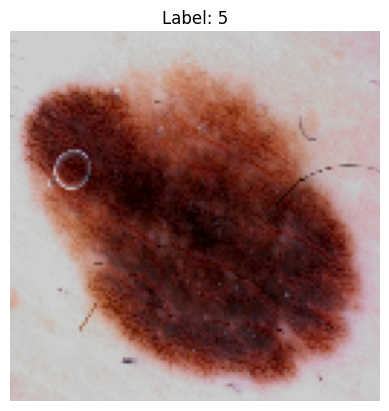

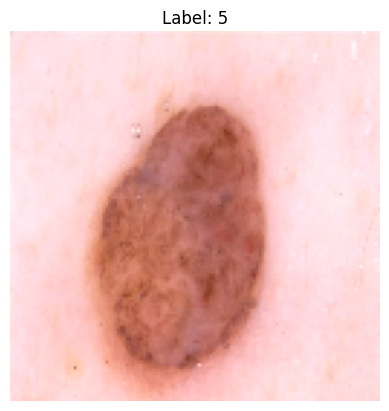

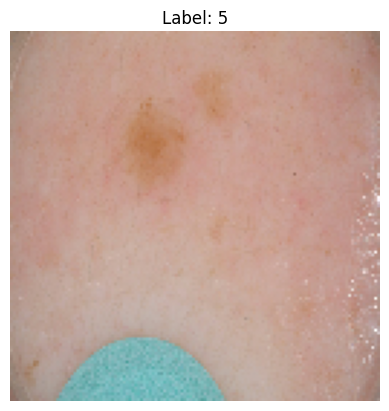

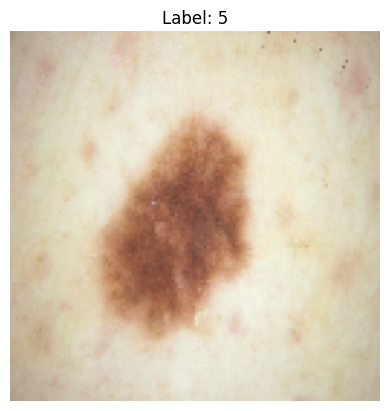

In [14]:
#Verifying preprocessing Take one batch will contain 32 images if batch_size=32
for batch_images, batch_labels in isic_dataset.take(1):
    for i in range(5):
        image = batch_images[i].numpy()
        label = batch_labels[i].numpy()

        # Convert one-hot label to class index if needed
        if len(label.shape) > 0 and label.shape[-1] > 1:
            label = tf.argmax(label).numpy()

        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

In [15]:
# have commented to save memory
'''image_count = 0
label_count = 0

for batch_images, batch_labels in isic_dataset:
    image_count += batch_images.shape[0]
    label_count += batch_labels.shape[0]

print(f"Total images in dataset: {image_count}")
print(f"Total labels in dataset: {label_count}")'''

Total images in dataset: 25331
Total labels in dataset: 25331


In [29]:
X = []
y = []
for image_batch, label_batch in isic_dataset:
    X.append(image_batch.numpy())
    y.append(label_batch.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

# Now you can use X and y in train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

KeyboardInterrupt: 

In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def get_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    ]
#The get_callbacks function to get the list of callbacks
callbacks = get_callbacks()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.6374 - loss: 1.0026 - val_accuracy: 0.7470 - val_loss: 0.7676
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 214ms/step - accuracy: 0.6245 - loss: 1.0279 - val_accuracy: 0.7530 - val_loss: 0.7796
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.6405 - loss: 0.9830 - val_accuracy: 0.7601 - val_loss: 0.7469
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.6440 - loss: 0.9726 - val_accuracy: 0.7621 - val_loss: 0.7040
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 216ms/step - accuracy: 0.6403 - loss: 0.9671 - val_accuracy: 0.7359 - val_loss: 0.7437
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.6313 - loss: 0.9883 - val_accuracy: 0.7450 - val_loss: 0.7628
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.6283 - loss: 0.9727 - val_accuracy: 0.7117 - val_loss: 0.8492
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.6538 -

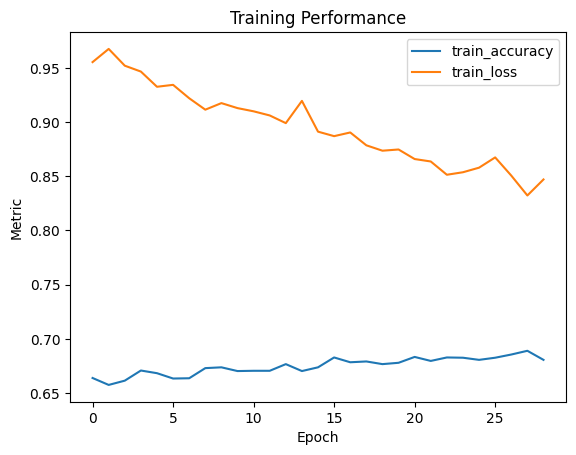

In [24]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training Performance')
plt.show()

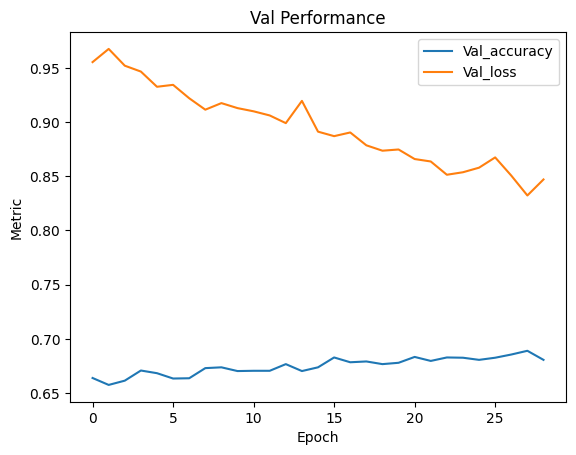

In [26]:
plt.plot(history.history['accuracy'], label='Val_accuracy')
plt.plot(history.history['loss'], label='Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Val Performance')
plt.show()

In [ ]:
# Save the model to your Google Drive
model_save_path = "/content/drive/MyDrive/POC_CNN_model"
model.save(model_save_path)
